In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Saving as a scenario

In [127]:
!ls -ltrh ../mat/*

-rw-r--r--  1 laurentperrinet  staff   118K Nov 30 14:16 ../mat/line_vague_solo.npy
-rw-r--r--  1 laurentperrinet  staff   104K Nov 30 14:16 ../mat/line_vague_dense.npy
-rw-r--r--  1 laurentperrinet  staff   416K Dec  2 13:55 ../mat/line_onde_dense.npy
-rw-r--r--  1 laurentperrinet  staff   416K Dec  2 13:55 ../mat/line_onde_solo.npy
-rw-r--r--  1 laurentperrinet  staff   1.4M Dec  2 15:39 ../mat/line_geometry.npy
-rw-r--r--  1 laurentperrinet  staff   1.4M Dec  2 16:00 ../mat/line_geometry_structure.npy
-rw-r--r--  1 laurentperrinet  staff   1.4M Dec  2 16:01 ../mat/line_geometry_45deg.npy
-rw-r--r--  1 laurentperrinet  staff   731K Dec  2 16:10 ../mat/line_fresnelastique.npy
-rw-r--r--  1 laurentperrinet  staff   731K Dec  2 16:13 ../mat/line_fresnelastique_chirp.npy
-rw-r--r--  1 laurentperrinet  staff   731K Dec  2 16:14 ../mat/line_fresnelastique_choc.npy


In [128]:
%%writefile ../scenario_line_master.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np
import os

def master(e, filename):
    if e.structure: N_lame = e.N_lame-e.struct_N
    else: N_lame = e.N_lame

    def montage(z, z_in, damp_tau=0.):
        z_out = z.copy()
        z_s = z_in.copy()
        #if damp_tau>0:
        #    max_time = z_in.shape[0]/e.desired_fps
        #    time = np.linspace(0., max_time, z_in.shape[0])
        #    smooth = 1.-np.exp((np.cos(2*np.pi* time / max_time)-1)/(damp_tau / max_time)**2)
        #    z_s[:, 1:] *= smooth[:, np.newaxis]

        #print (z_out[0, 0], z_out[-1, 0], z_s[0, 0], z_s[-1, 0])
        z_s[:, 0] += z_out[-1, 0] + 1./e.desired_fps # increment the time on the new array
        #print (z_out.shape, z_s.shape, z_s[0, 0], z_s[-1, 0])
        return np.vstack((z_out, z_s))

    def revert(z_in):
        z_s = z_in.copy()
        z_s[:, 1:] = z_s[:, 1:][:, ::-1]
        return z_s

    def mirror(z_in):
        z_s = z_in.copy()
        z_s[:, 1:] = -z_s[:, 1:]
        return z_s

    def interleave(z_1, z_2):
        z_s_1 = z_1.copy()
        z_s_2 = z_2.copy()
        z_s_1[:, 1::2] = z_s_2[:, 1::2]
        return z_s_1
            
    matpath = 'mat/'
    z_s = {}
    #print('importing scenarii')
    for scenario in [#'line_vague_dense', 'line_vague_solo', 
                     'line_onde_dense', 'line_onde_solo', 'line_fresnelastique',
                    'line_fresnelastique_choc', 'line_fresnelastique_chirp', 
                     'line_geometry', 'line_geometry_45deg', 'line_geometry_structure']:
        z_s[scenario] = np.load(os.path.join(matpath, scenario + '.npy'))
        #print(scenario)
        el.check(e, z_s[scenario])
    #print('finished importing scenarii')    
    ###########################################################################
    burnout_time = 4.
    z = np.zeros((1, N_lame+1)) # zero at zero
    z = np.vstack((z, np.hstack((np.array(burnout_time), np.zeros(N_lame) ))))
    ###########################################################################
    z = montage(z, z_s['line_onde_dense'])
    ###########################################################################
    z = montage(z, z_s['line_geometry_45deg'])
    z = montage(z, z_s['line_geometry_structure'])
    z = montage(z, z_s['line_geometry'])
    z = montage(z, mirror(z_s['line_geometry_45deg']))
    ###########################################################################
    z = montage(z, z_s['line_onde_solo'])
    z = montage(z, revert(z_s['line_onde_solo']))
    z = montage(z, revert(z_s['line_onde_dense']))
    ###########################################################################
    z = montage(z, z_s['line_geometry'])
    z = montage(z, z_s['line_fresnelastique'])
    z = montage(z, z_s['line_geometry_structure'])
    z = montage(z, mirror(z_s['line_fresnelastique']))
    z = montage(z, z_s['line_fresnelastique_chirp'])
    z = montage(z, z_s['line_fresnelastique_choc'])
    z = montage(z, z_s['line_geometry'])
    z = montage(z, z_s['line_geometry_structure'])
    ###########################################################################
    z = montage(z, z_s['line_fresnelastique'])
    z = montage(z, interleave(z_s['line_fresnelastique'], mirror(z_s['line_fresnelastique'])))
    z = montage(z, interleave(z_s['line_fresnelastique_chirp'], mirror(z_s['line_fresnelastique_choc'])))
    z = montage(z, interleave(z_s['line_fresnelastique_choc'], mirror(z_s['line_fresnelastique_chirp'])))
    ###########################################################################
    z = montage(z, z_s['line_geometry'])
    z = montage(z, z_s['line_onde_dense'])
    
    ###########################################################################
    # check that there is not overflow @ 30 fps
    el.check(e, z)
    ###########################################################################
    # save the file
    np.save(filename, z)

    return z_s

if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
        
    filename = 'mat/master.npy'
    e = el.EdgeGrid(N_lame=25, grid_type='line', mode=mode,
                 verb=False, filename=filename)

    if mode == 'writer':
        z_s = master(e, filename)
    else:
        # running the code
        el.main(e)


Overwriting ../scenario_line_master.py


In [129]:
%cd ..
!rm mat/master.npy
%run  scenario_line_master.py writer
%cd posts

/Users/laurentperrinet/cloud_nas/science/elasticte
rm: mat/master.npy: No such file or directory
!! /Z\ !! @  23650  overflow @  9 181 2.379375
!! /Z\ !! @  23650  overflow @  16 154 2.025
!! /Z\ !! @  44194  overflow @  9 181 2.375625
!! /Z\ !! @  44194  overflow @  16 154 2.025
!! /Z\ !! @  72994  overflow @  9 181 2.37937500001
!! /Z\ !! @  72994  overflow @  16 154 2.02875
!! /Z\ !! @  101794  overflow @  9 180 2.37000000002
!! /Z\ !! @  101794  overflow @  16 154 2.0325
/Users/laurentperrinet/cloud_nas/science/elasticte/posts


(0.0, 103841.0, 0.0, 3465.333333333333)

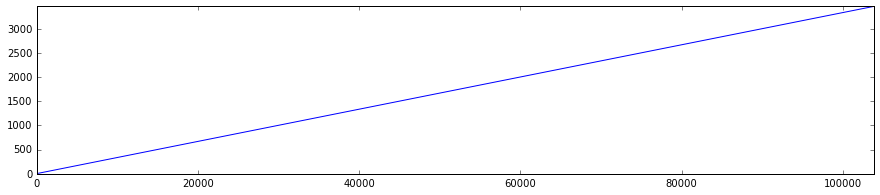

In [130]:
z = np.load('../mat/master.npy')
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(z[:, 0])
ax.axis('tight')

(0.0, 3465.333333333333, -1.5707796216956762, 1.5707898891455674)

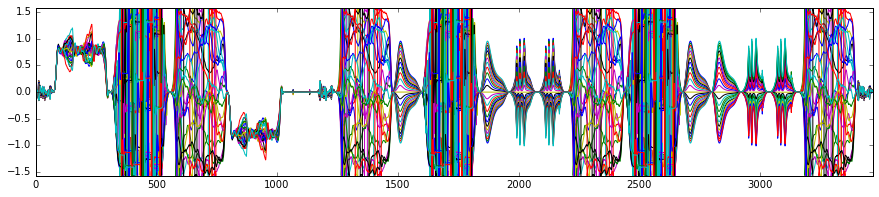

In [131]:
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(z[:, 0], z[:, 1:])
ax.axis('tight')

## utile

7200 240.0
[ 0.          0.39508627  0.86180549  0.98691779  0.99940489  0.9999842
  0.99999969  0.99999999  1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          0.99999999
  0.99999969  0.9999842   0.99940489  0.98691779  0.86180549  0.39508627
  0.        ]


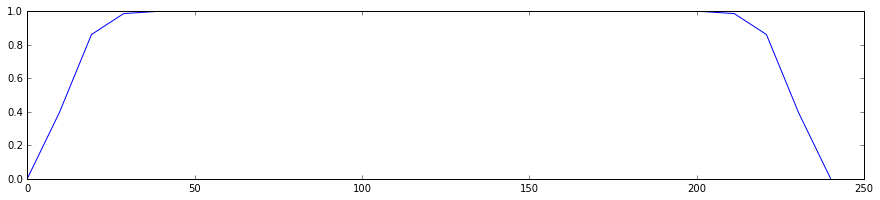

In [132]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
damp_tau = 60.
max_time = z_s['line_geometry'].shape[0]/e.desired_fps
time = np.linspace(0., max_time, z_s['line_geometry'].shape[-1])
print(z_s['line_geometry'].shape[0], max_time)
#smooth = 1.-np.exp(-(np.mod(time+max_time/2, max_time)-max_time/2)**2/damp_tau**2)
smooth = 1.-np.exp((np.cos(2*np.pi* time / max_time)-1)/(damp_tau / max_time)**2)
print (smooth)
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(time, smooth)

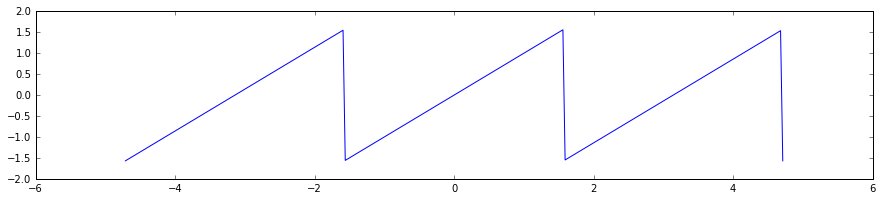

In [133]:
angle_actuel = np.linspace(-1.5*np.pi, 1.5*np.pi, 300)
angle_actuel_ = np.mod(angle_actuel + np.pi/2, np.pi) - np.pi/2
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(angle_actuel, angle_actuel_)

## git


In [134]:
! git add ../mat/master.npy
!git s

 M ../mat/line_fresnelastique.npy
 M ../mat/line_fresnelastique_chirp.npy
 M ../mat/line_fresnelastique_choc.npy
 M ../mat/line_geometry.npy
 M ../mat/line_geometry_45deg.npy
 M ../mat/line_geometry_structure.npy
M  ../mat/master.npy
 M "2015-10-14 \303\251lasticit\303\251, Fresnel.ipynb"
 M "2015-11-17 \303\251lasticit\303\251 expansion en miroir - dynamique d'un point focal.ipynb"
 M "2015-11-26 \303\251lasticit\303\251 - sc\303\251nario montage.ipynb"
 M "2015-11-27 \303\251lasticit\303\251, geometrie.ipynb"
 M ../scenario_line_elastic_fresnel.py
 M ../scenario_line_elastic_fresnel_chirp.py
 M ../scenario_line_elastic_fresnel_choc.py
 M ../scenario_line_geometry_45deg.py
 M ../scenario_line_geometry_structure.py
 M ../scenario_line_master.py
 M ../src/elasticite.py


In [135]:
!git commit -am' scenario master '

[master 3941126]  scenario master
 18 files changed, 4776 insertions(+), 2038 deletions(-)
 rewrite mat/line_fresnelastique.npy (90%)
 rewrite mat/line_fresnelastique_chirp.npy (90%)
 rewrite mat/line_fresnelastique_choc.npy (90%)
 rewrite mat/line_geometry.npy (82%)
 rewrite mat/line_geometry_45deg.npy (82%)
 rewrite mat/line_geometry_structure.npy (81%)
 copy "posts/2015-10-14 \303\251lasticit\303\251, Fresnel.ipynb" => mat/master.npy (62%)
 rewrite "posts/2015-10-14 \303\251lasticit\303\251, Fresnel.ipynb" (99%)
 rewrite "posts/2015-11-26 \303\251lasticit\303\251 - sc\303\251nario montage.ipynb" (88%)
 rewrite "posts/2015-11-27 \303\251lasticit\303\251, geometrie.ipynb" (93%)


In [136]:
! git push

Counting objects: 23, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (23/23), done.
Writing objects: 100% (23/23), 34.50 MiB | 4.27 MiB/s, done.
Total 23 (delta 15), reused 0 (delta 0)
To git@git.framasoft.org:laurentperrinet/elasticte.git
   fb34b7e..3941126  master -> master


In [137]:
%pwd

'/Users/laurentperrinet/cloud_nas/science/elasticte/posts'